### Exploratory Data Analysis (Receipts OCR)
Data source example: https://expressexpense.com/blog/free-receipt-images-ocr-machine-learning-dataset/

This notebook performs a practical EDA for an AI program that reads receipt information (OCR + field extraction).
It covers: inventory, image quality, layout diversity, (optional) labels profiling, baseline OCR probe, field extraction probes, error metrics, leakage-safe splits, and visual reports.


## 0) Setup & Configuration
- Adjust paths to match your dataset.
- Optional dependencies (pytesseract, scikit-learn, jiwer) are guarded with try/except. Install if needed.
- The notebook aims to run even if some optional packages are missing; those sections will be skipped with a message.


In [1]:
from pathlib import Path
import os, json, hashlib
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

# Default dataset layout in this repo
IMG_DIR = Path('train_data/images')
LABELS_CSV = Path('train_data/gdt')

print('Images:', IMG_DIR.resolve())
print('Labels CSV:', LABELS_CSV.resolve())

# Output directory for any reports
OUT_DIR = Path('eda_outputs'); OUT_DIR.mkdir(exist_ok=True)
print('Output dir:', OUT_DIR.resolve())


Images: /Users/Ian/Workshop/LIVE-AI_Best-Coast/train_data/images
Labels CSV: /Users/Ian/Workshop/LIVE-AI_Best-Coast/train_data/gdt
Output dir: /Users/Ian/Workshop/LIVE-AI_Best-Coast/eda_outputs


## 1) Inventory and Metadata
- Count images, formats, sizes, aspect ratios.
- Detect duplicates (md5) and corrupted files.


In [2]:
def file_hash(p: Path):
    h = hashlib.md5()
    with open(p, 'rb') as f: h.update(f.read())
    return h.hexdigest()

rows = []
image_paths = []
if IMG_DIR.exists():
    for root, _, files in os.walk(IMG_DIR):
        for fn in files:
            fp = Path(root) / fn
            if not (fn.lower().endswith('.jpg') or fn.lower().endswith('.jpeg') or fn.lower().endswith('.png') or fn.lower().endswith('.tif') or fn.lower().endswith('.tiff')):
                continue
            try:
                with Image.open(fp) as im:
                    rows.append({
                        'path': str(fp),
                        'format': im.format,
                        'mode': im.mode,
                        'width': im.width,
                        'height': im.height,
                        'aspect': (im.width / im.height) if im.height else None,
                        'hash': file_hash(fp)
                    })
                    image_paths.append(str(fp))
            except Exception as e:
                rows.append({'path': str(fp), 'error': str(e)})
else:
    print('IMG_DIR does not exist:', IMG_DIR)

img_df = pd.DataFrame(rows)
print('Total files scanned:', len(rows))
if not img_df.empty:
    print('Corrupted/Errors:', img_df['error'].notna().sum() if 'error' in img_df else 0)
    if 'hash' in img_df:
        nunique = img_df['hash'].nunique()
        print('Duplicates by MD5:', len(img_df) - nunique)
img_df.head()


Total files scanned: 967
Corrupted/Errors: 0
Duplicates by MD5: 15


,path,format,mode,width,height,aspect,hash
0,train_data/images/823.jpg,JPEG,RGB,623,1471,0.423521,fd6a6a6fab21be24450804bb0eccdcdc
1,train_data/images/189.jpg,JPEG,RGB,1654,2338,0.707442,6f024a44f3fe3f035510dad1a1e6315f
2,train_data/images/837.jpg,JPEG,RGB,615,1479,0.415822,89a1fc16d3ec30d57335160afc3483e8
3,train_data/images/638.jpg,JPEG,RGB,4961,7016,0.707098,556a2984a8881917121f05049713344d
4,train_data/images/604.jpg,JPEG,RGB,708,1699,0.416716,92dfc6de98f79d1dad2bc820a2ae7b62


## 2) Image Quality Diagnostics
- Blur (Laplacian variance) --> measures how sharp edges are
- Brightness and contrast.
- Skew angle estimate (rough) --> measures how tilted the receipt is
- Histograms to inspect distributions.


In [3]:
import numpy as np

import cv2
def _read_gray(img):
    # robust read supporting non-ASCII paths
    data = np.fromfile(img, dtype=np.uint8)
    return cv2.imdecode(data, cv2.IMREAD_GRAYSCALE)

def blur_score(file_path):
    img = _read_gray(file_path)
    if img is None: return np.nan
    return float(cv2.Laplacian(img, cv2.CV_64F).var())

def brightness_contrast(file_path):
    img = _read_gray(file_path)
    if img is None: return (np.nan, np.nan)
    return float(np.mean(img)), float(np.std(img))

def estimate_skew(file_path):
    img = _read_gray(file_path)
    if img is None: return np.nan
    edges = cv2.Canny(img, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=200)
    if lines is None: return 0.0
    angles = [(theta - np.pi/2) for (rho, theta) in lines[:,0]]
    angles_deg = np.degrees(angles)
    return float(np.median(angles_deg))

In [4]:
img_df['blur'] = img_df['path'].apply(blur_score)
img_df[['brightness','contrast']] = img_df['path'].apply(lambda p: pd.Series(brightness_contrast(p)))
img_df['skew_deg'] = img_df['path'].apply(estimate_skew)
img_df = img_df.dropna(axis=0, how="any")

Corrupt JPEG data: 33 extraneous bytes before marker 0xd9
Corrupt JPEG data: 33 extraneous bytes before marker 0xd9
Corrupt JPEG data: 33 extraneous bytes before marker 0xd9


#### Image Quality Analysis
Let us plot and explore the extremes of the following metrics: aspect ratio, width, blur (Laplacian variance), brightness (mean), contrast (std), and skew (deg).

In [41]:
# Helper utilities to visualize metric distributions and extremes
import math

def plot_metric_and_extremes(df, col, bins=30, color='steelblue', xlabel=None, title=None):
    if df is None or df.empty or col not in df.columns:
        print(f'Skipping {col}: missing or empty.')
        return
    # Histogram
    sns.histplot(df[col].dropna(), color=color, bins=bins)
    plt.title(title or col)
    plt.xlabel(xlabel or col)
    plt.ylabel('Count')
    plt.show()
    # Summary
    print(df[col].describe())
    # Extremes tables
    smallest = df.nsmallest(5, col)[['path', col]]
    largest = df.nlargest(5, col)[['path', col]]
    print(f"\n5 smallest {col}:")
    print(smallest)
    print(f"\n5 largest {col}:")
    print(largest)
    # Image grids
    def show_rows(rows, suptitle):
        if rows.empty:
            print('No rows to display')
            return
        n = len(rows)
        fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
        if n == 1:
            axes = [axes]
        for ax, (_, r) in zip(axes, rows.iterrows()):
            img = _read_gray(r['path'])
            if img is not None:
                ax.imshow(img, cmap='gray')
            ax.set_title(f"{r[col]:.2f}")
            ax.axis('off')
        plt.suptitle(suptitle)
        plt.tight_layout()
        plt.show()
    show_rows(smallest, f"Top 5 Smallest {col}")
    show_rows(largest, f"Top 5 Largest {col}")


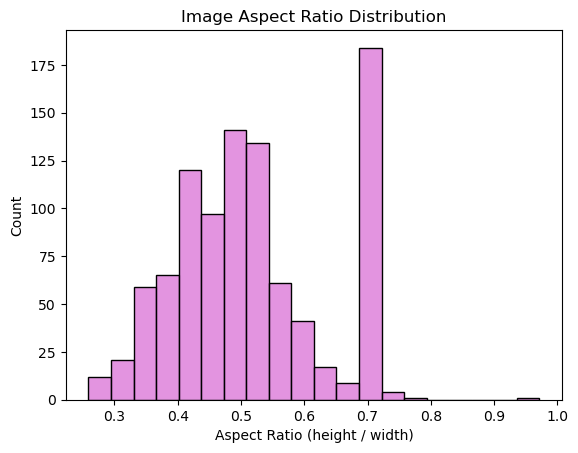

count    967.000000
mean       0.516096
std        0.120084
min        0.258861
25%        0.424166
50%        0.501425
75%        0.590056
max        0.971354
Name: aspect, dtype: float64

5 smallest aspect:
                          path    aspect
163  train_data/images/167.jpg  0.258861
460  train_data/images/450.jpg  0.263498
477  train_data/images/040.jpg  0.265834
621  train_data/images/537.jpg  0.272130
676  train_data/images/723.jpg  0.281780

5 largest aspect:
                          path    aspect
882  train_data/images/568.jpg  0.971354
919  train_data/images/350.jpg  0.765289
401  train_data/images/272.jpg  0.739324
130  train_data/images/776.jpg  0.724473
620  train_data/images/279.jpg  0.724369


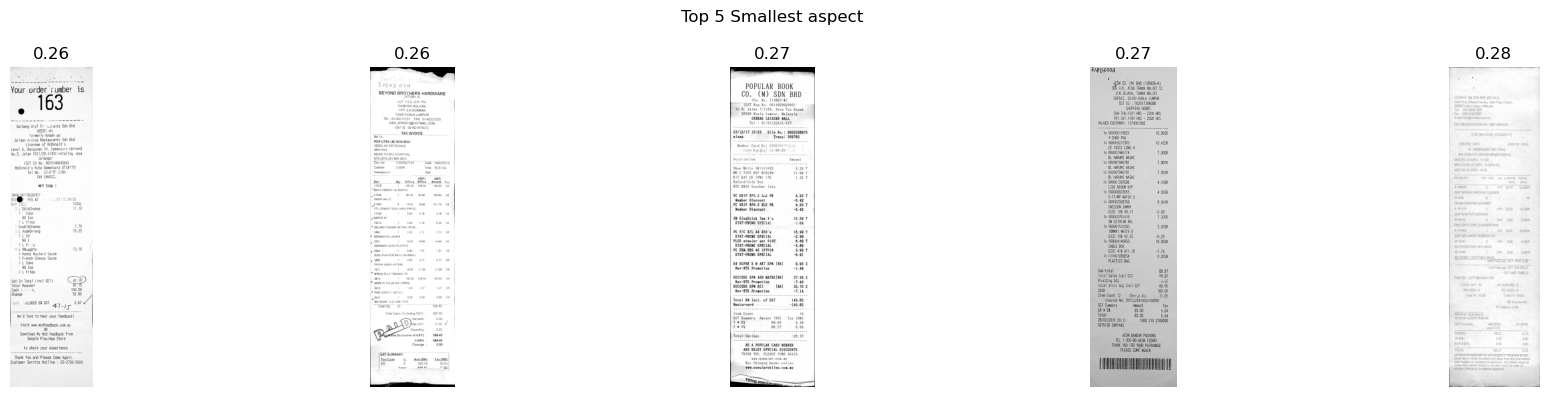

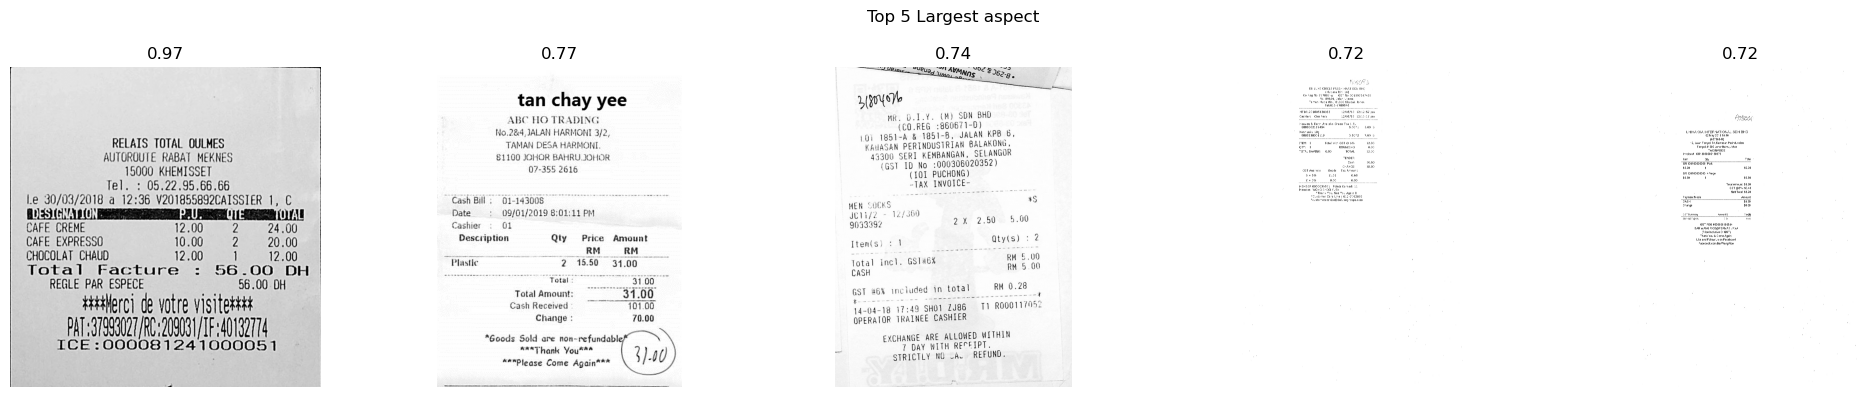

In [49]:
# 2a. Aspect Ratio
plot_metric_and_extremes(img_df, 'aspect', bins=20, color='orchid', xlabel='Aspect Ratio (height / width)', title='Image Aspect Ratio Distribution')

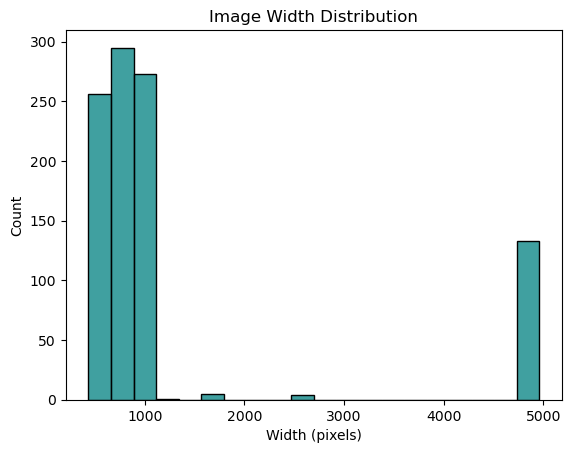

count     967.000000
mean     1362.669080
std      1448.438081
min       435.000000
25%       626.000000
50%       818.000000
75%       935.000000
max      4961.000000
Name: width, dtype: float64

5 smallest width:
                          path  width
907  train_data/images/191.jpg    435
25   train_data/images/764.jpg    436
238  train_data/images/075.jpg    439
244  train_data/images/074.jpg    439
438  train_data/images/663.jpg    439

5 largest width:
                         path  width
3   train_data/images/638.jpg   4961
22  train_data/images/770.jpg   4961
28  train_data/images/771.jpg   4961
44  train_data/images/177.jpg   4961
48  train_data/images/639.jpg   4961


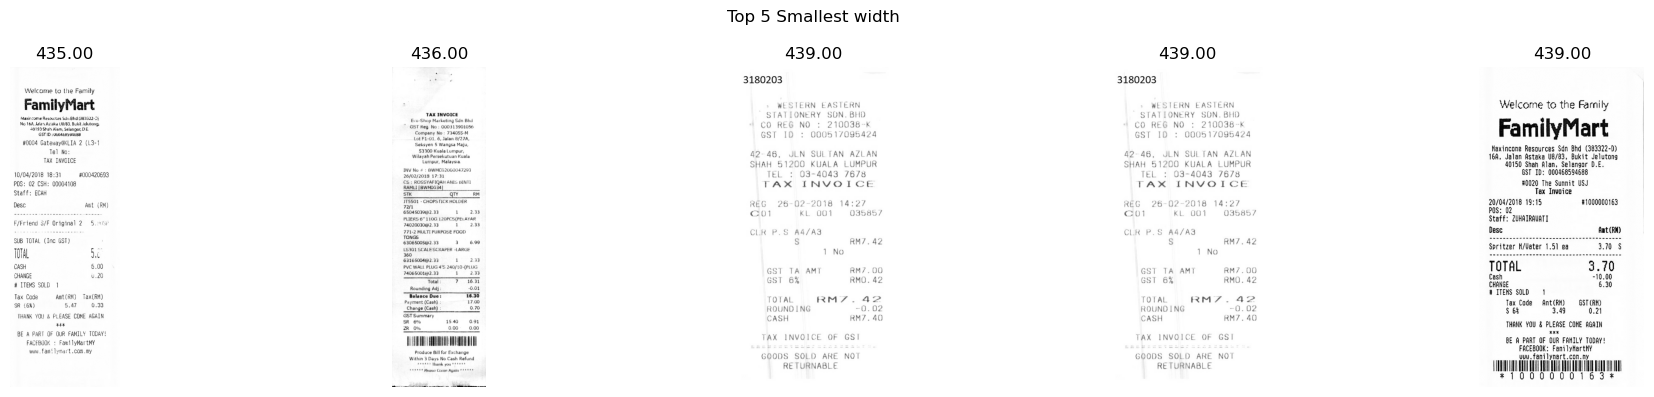

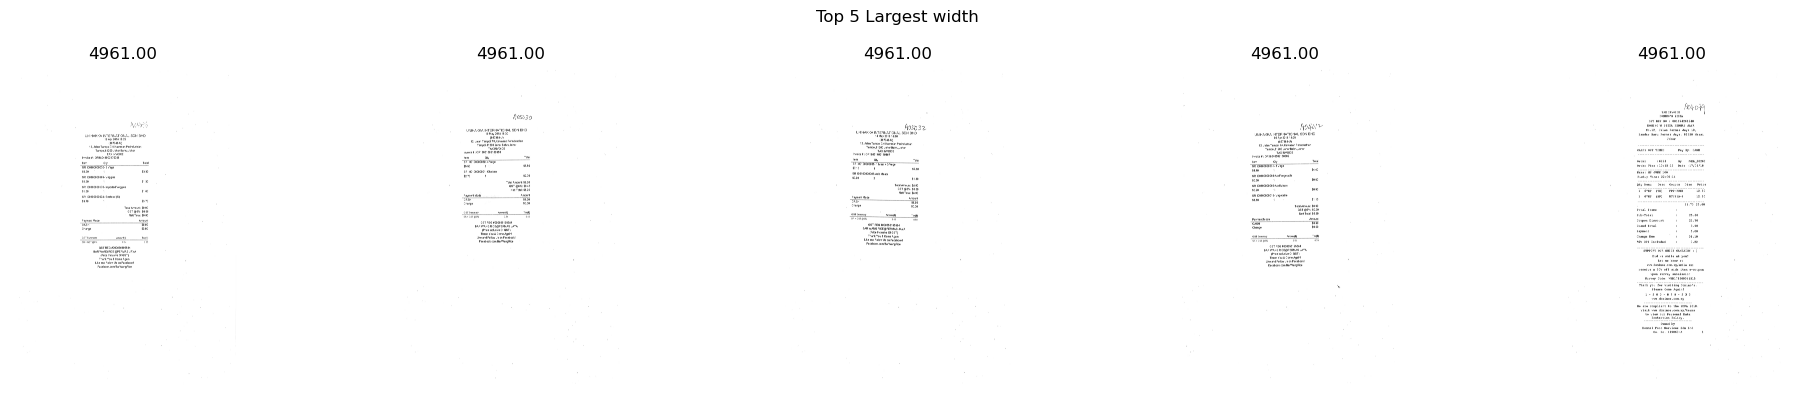

In [42]:
# 2b. Width
plot_metric_and_extremes(img_df, 'width', bins=20, color='teal', xlabel='Width (pixels)', title='Image Width Distribution')


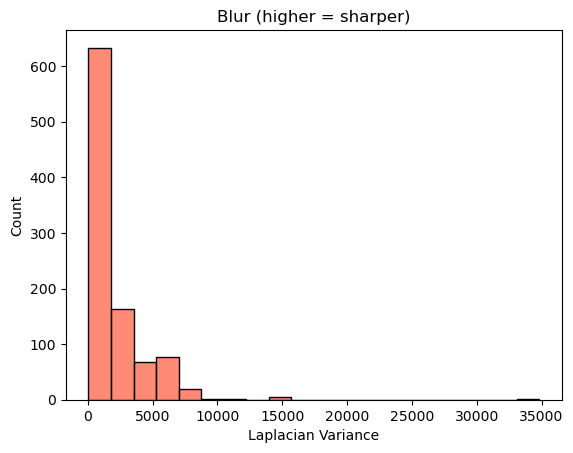

count      967.000000
mean      1973.459316
std       2387.994266
min         58.566787
25%        421.093760
50%       1240.951541
75%       2447.046180
max      34832.423230
Name: blur, dtype: float64

5 smallest blur:
                          path       blur
355  train_data/images/729.jpg  58.566787
295  train_data/images/738.jpg  63.098566
600  train_data/images/250.jpg  71.370147
681  train_data/images/736.jpg  90.388743
809  train_data/images/747.jpg  94.289973

5 largest blur:
                          path          blur
23   train_data/images/016.jpg  34832.423230
318  train_data/images/498.jpg  15334.985990
116  train_data/images/372.jpg  14407.002832
655  train_data/images/496.jpg  14346.439454
700  train_data/images/497.jpg  14170.881040


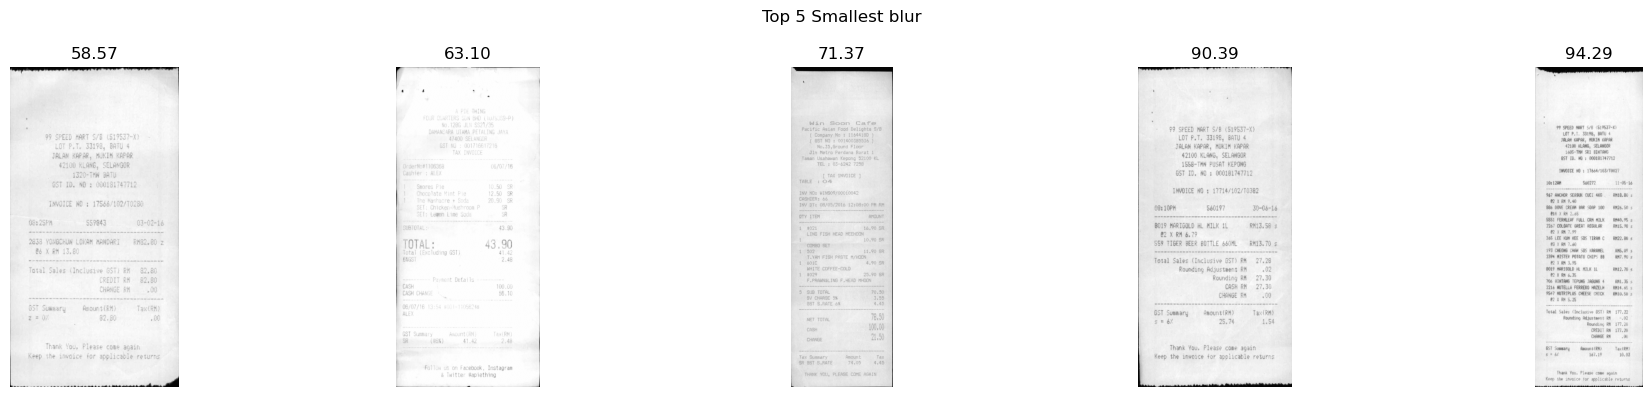

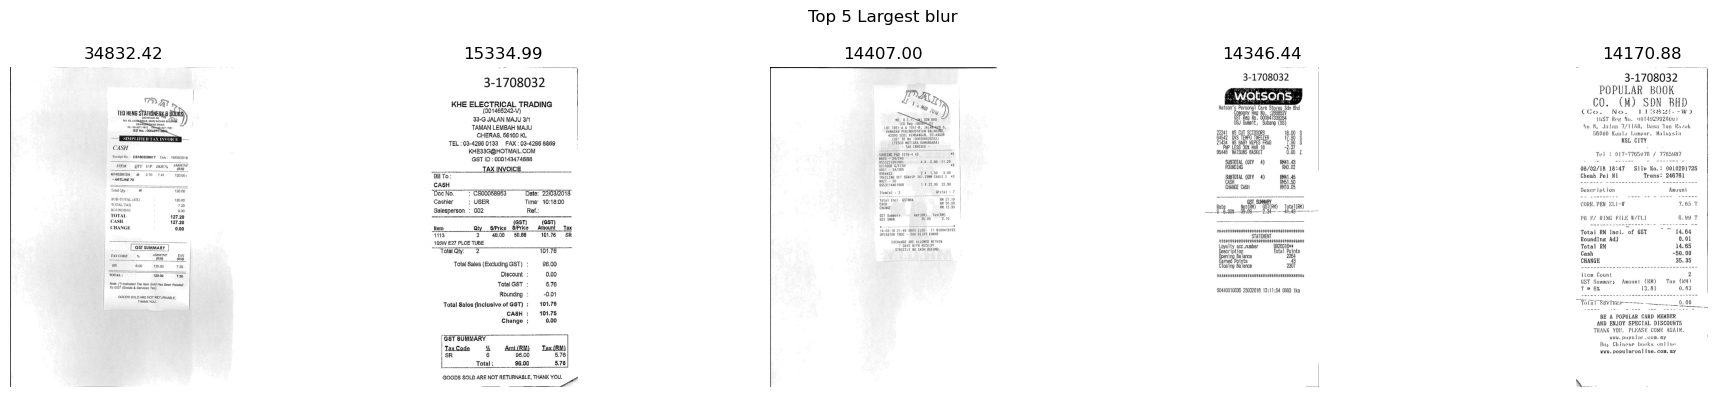

In [43]:
# 2c. Blur (Laplacian variance)
plot_metric_and_extremes(img_df, 'blur', bins=20, color='tomato', xlabel='Laplacian Variance', title='Blur (higher = sharper)')


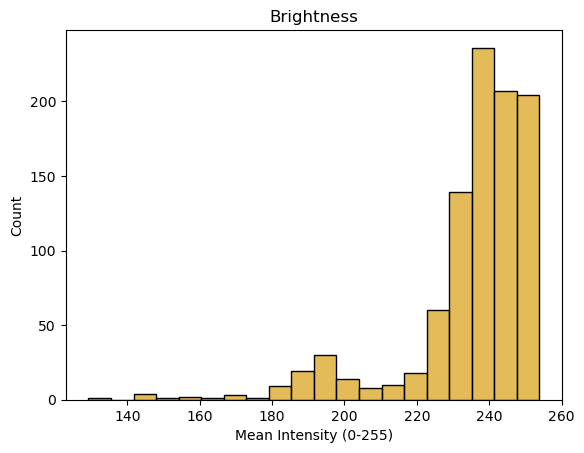

count    967.000000
mean     235.446864
std       17.935420
min      129.269415
25%      232.333806
50%      239.426648
75%      246.079608
max      253.836717
Name: brightness, dtype: float64

5 smallest brightness:
                          path  brightness
252  train_data/images/510.jpg  129.269415
863  train_data/images/569.jpg  142.733319
16   train_data/images/572.jpg  144.342084
69   train_data/images/571.jpg  144.516768
768  train_data/images/142.jpg  146.919035

5 largest brightness:
                          path  brightness
956  train_data/images/392.jpg  253.836717
900  train_data/images/636.jpg  253.718854
738  train_data/images/779.jpg  253.561398
92   train_data/images/404.jpg  253.502935
875  train_data/images/030.jpg  253.467127


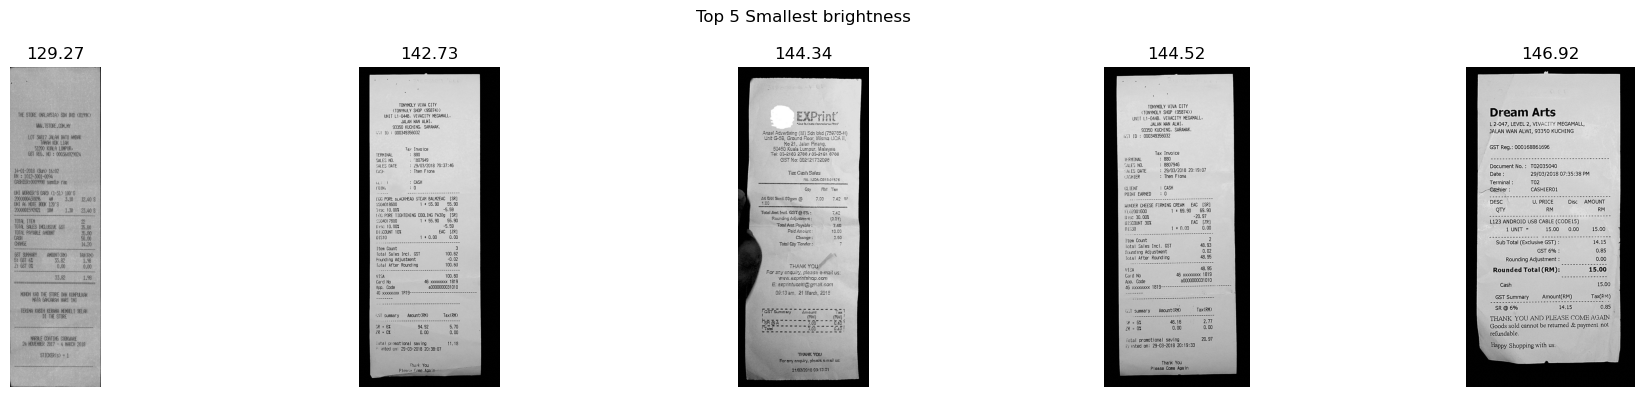

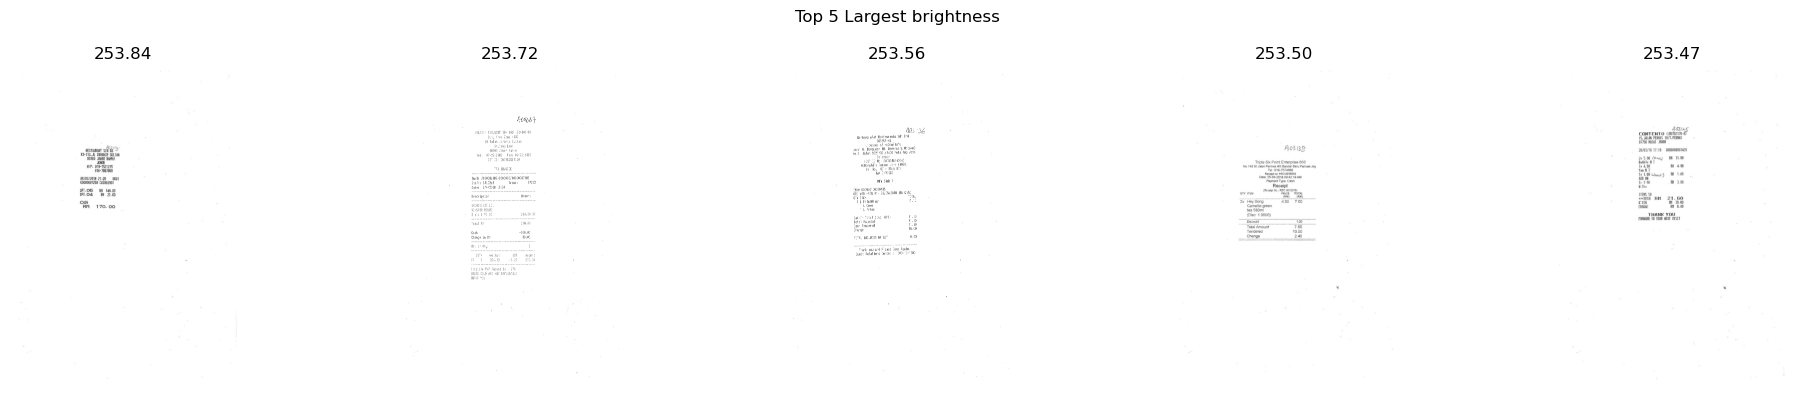

In [44]:
# 2d. Brightness
plot_metric_and_extremes(img_df, 'brightness', bins=20, color='goldenrod', xlabel='Mean Intensity (0-255)', title='Brightness')


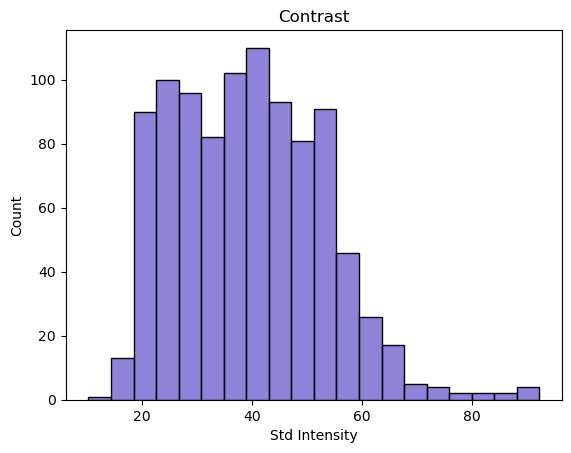

count    967.000000
mean      39.477445
std       13.397231
min       10.255632
25%       28.312080
50%       38.970817
75%       48.662946
max       92.303313
Name: contrast, dtype: float64

5 smallest contrast:
                          path   contrast
645  train_data/images/858.jpg  10.255632
786  train_data/images/418.jpg  14.520653
878  train_data/images/965.jpg  14.520653
851  train_data/images/384.jpg  15.079676
956  train_data/images/392.jpg  15.678270

5 largest contrast:
                          path   contrast
863  train_data/images/569.jpg  92.303313
768  train_data/images/142.jpg  91.301328
69   train_data/images/571.jpg  91.209229
718  train_data/images/143.jpg  89.620984
749  train_data/images/793.jpg  84.956260


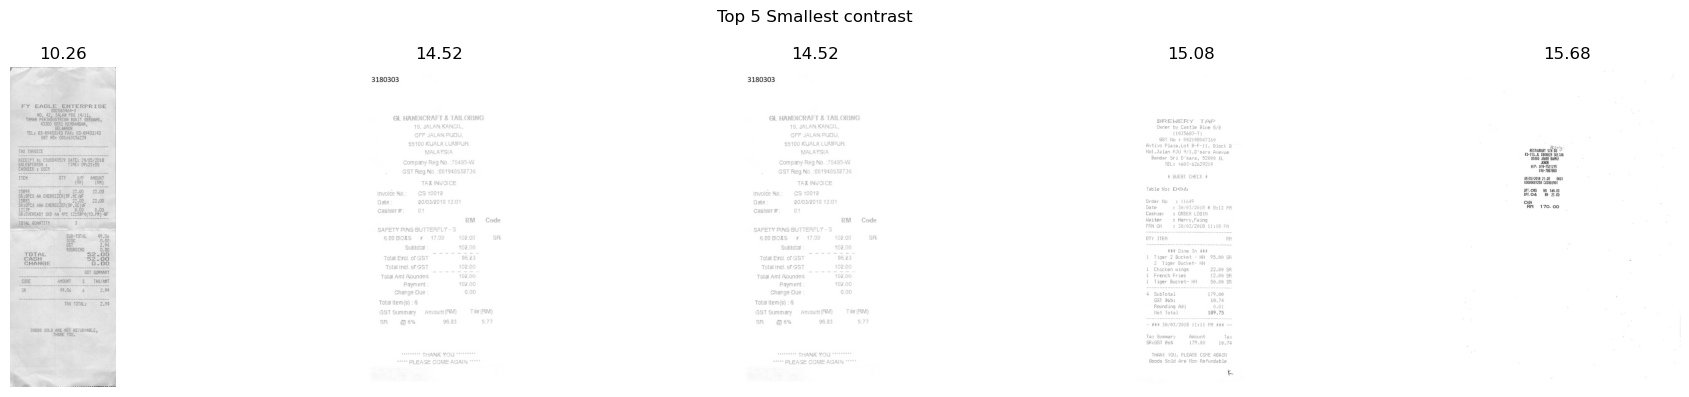

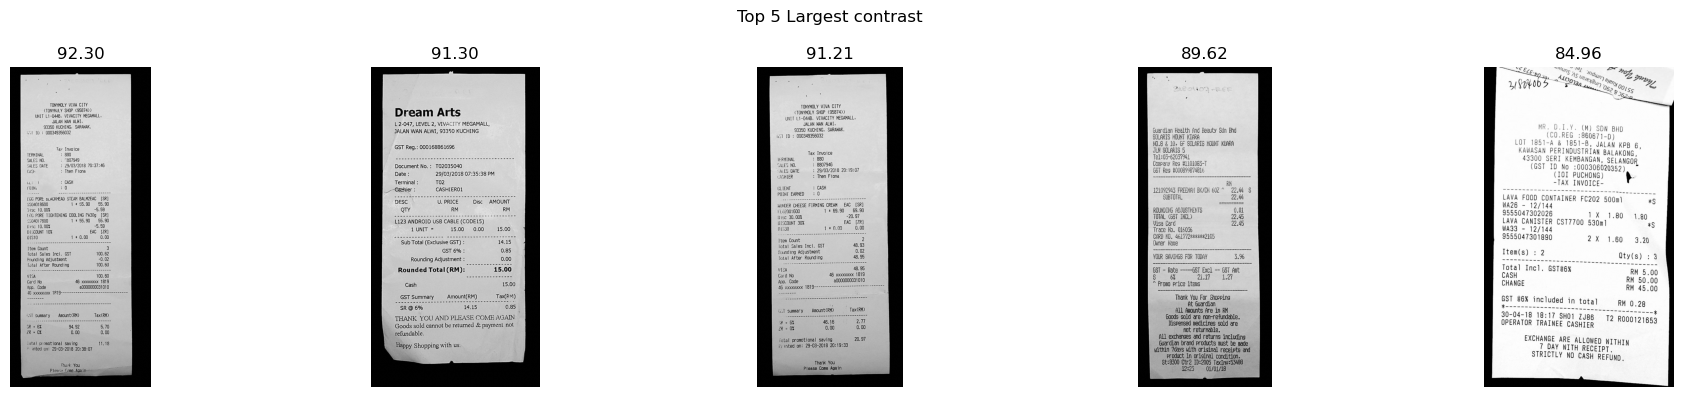

In [45]:
# 2e. Contrast
plot_metric_and_extremes(img_df, 'contrast', bins=20, color='slateblue', xlabel='Std Intensity', title='Contrast')


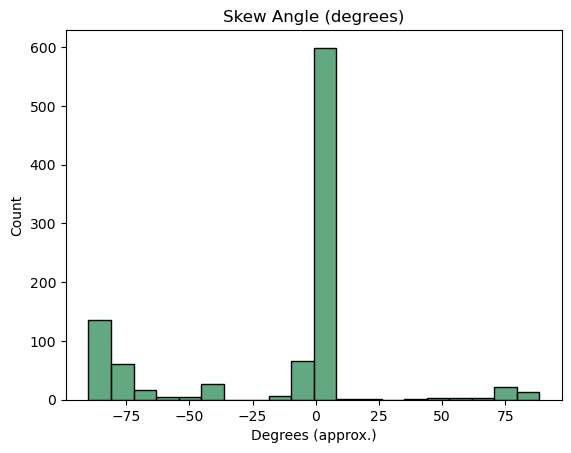

count    967.000000
mean     -16.697000
std       39.885859
min      -90.000000
25%      -43.749999
50%        0.000003
75%        0.000003
max       88.500000
Name: skew_deg, dtype: float64

5 smallest skew_deg:
                         path  skew_deg
26  train_data/images/003.jpg     -90.0
43  train_data/images/349.jpg     -90.0
53  train_data/images/820.jpg     -90.0
68  train_data/images/565.jpg     -90.0
94  train_data/images/376.jpg     -90.0

5 largest skew_deg:
                          path   skew_deg
748  train_data/images/787.jpg  88.500000
720  train_data/images/631.jpg  88.000003
737  train_data/images/786.jpg  88.000003
738  train_data/images/779.jpg  88.000003
940  train_data/images/755.jpg  88.000003


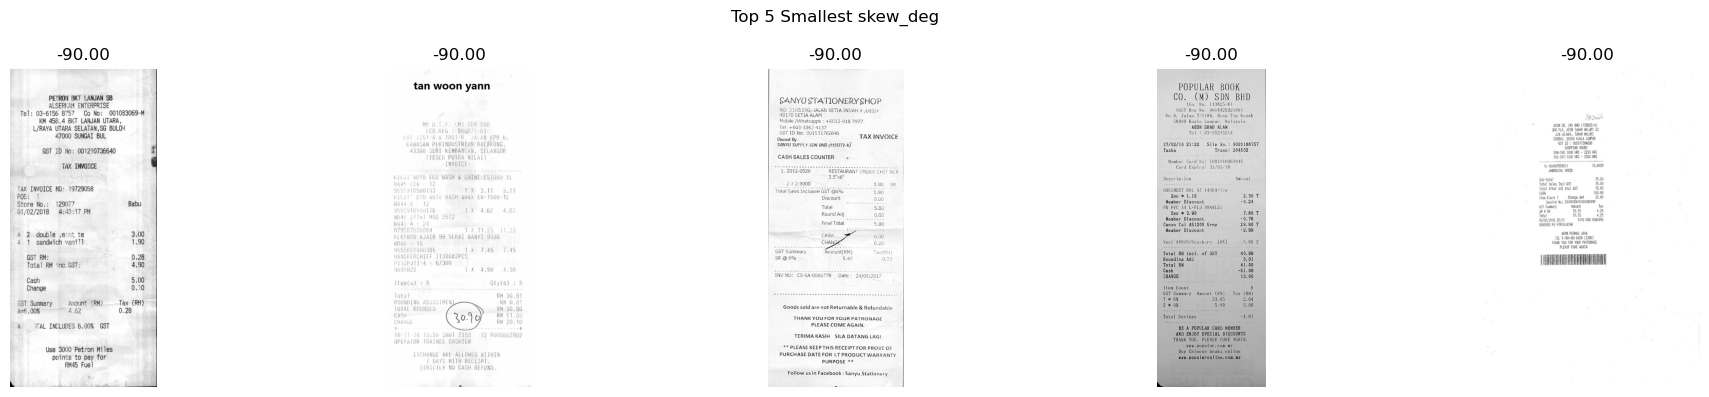

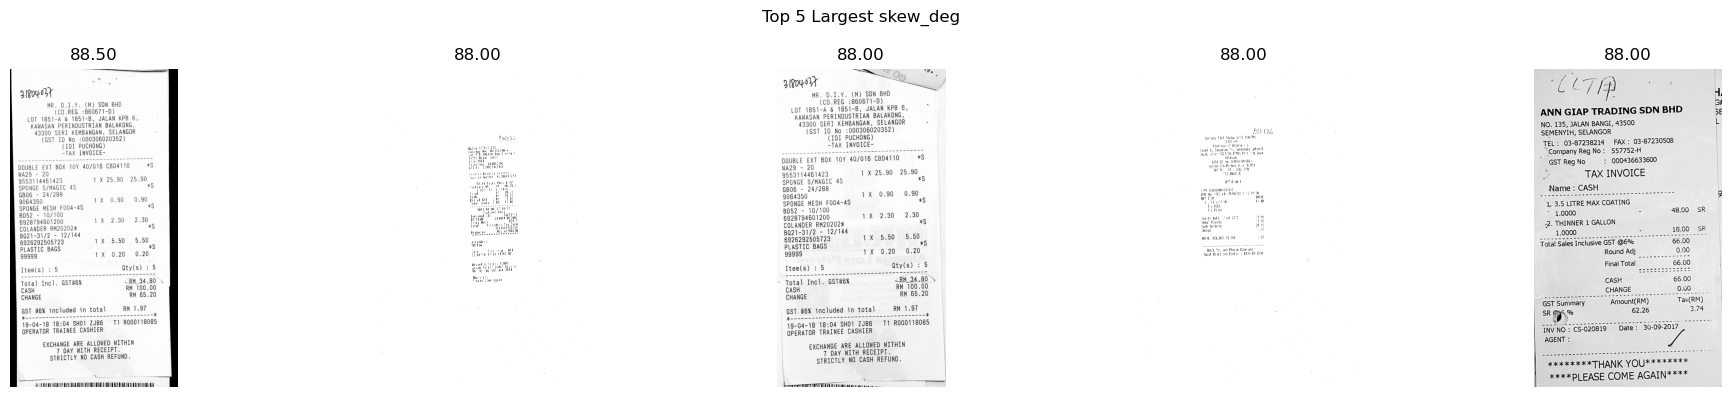

In [46]:
# 2f. Skew (degrees)
plot_metric_and_extremes(img_df, 'skew_deg', bins=20, color='seagreen', xlabel='Degrees (approx.)', title='Skew Angle (degrees)')


## 3) Layout and Template Diversity
Cluster thumbnails to estimate number of layout families; use for leakage-safe splits later.


In [ ]:
try:
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans
    feats, paths = [], []
    for p in img_df.get('path', []) if 'path' in img_df else []:
        try:
            im = Image.open(p).convert('L').resize((64, 64))
            feats.append(np.array(im).flatten()/255.0)
            paths.append(p)
        except Exception:
            pass
    if feats:
        X = np.stack(feats)
        n_comp = int(min(32, X.shape[0], X.shape[1])) if X.ndim == 2 else 8
        n_comp = max(2, n_comp)
        pca = PCA(n_components=n_comp).fit_transform(X)
        n_clusters = min(8, max(1, len(paths)//20) or 1)
        km = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42).fit(pca)
        clusters = pd.DataFrame({'path': paths, 'cluster': km.labels_})
        display(clusters['cluster'].value_counts())
    else:
        clusters = pd.DataFrame(columns=['path','cluster'])
        print('No features computed; skipping clustering')
except ModuleNotFoundError:
    clusters = pd.DataFrame(columns=['path','cluster'])
    print('scikit-learn not installed; skipping clustering. Install with: pip install scikit-learn')


## 4) Labels / Field Profiling (optional)
If you have a labels CSV, we will profile missingness and plausibility (subtotal + tax ≈ total).


In [ ]:
labels = None
if LABELS_CSV and Path(LABELS_CSV).exists():
    labels = pd.read_csv(LABELS_CSV)
    display(labels.head())
    print('Rows:', len(labels))
    missing = labels.isna().mean().sort_values(ascending=False)
    display(missing)
    needed = {'subtotal','tax','total'}
    if needed.issubset(labels.columns):
        check = labels.copy()
        for c in needed:
            check[c] = pd.to_numeric(check[c], errors='coerce')
        check['total_expected'] = check['subtotal'] + check['tax']
        check['delta'] = (check['total'] - check['total_expected']).abs()
        print('% rows with |total - (subtotal+tax)| > 0.05:', float((check['delta']>0.05).mean()))
    if labels is not None and 'date' in labels.columns:
        labels['date_parsed'] = pd.to_datetime(labels['date'], errors='coerce', infer_datetime_format=True)
        print('Invalid dates:', float(labels['date_parsed'].isna().mean()))
else:
    print('No labels CSV detected; skipping label profiling.')


## 5) Baseline OCR Probe (optional)
Run a light OCR on a sample to gauge text coverage and failures.


In [ ]:
try:
    import random
    import cv2
    import pytesseract
    sample_paths = []
    if 'img_df' in globals() and not img_df.empty:
        sample_paths = random.sample(list(img_df['path']), k=min(50, len(img_df)))
    def ocr_text(fp):
        data = np.fromfile(fp, dtype=np.uint8)
        img = cv2.imdecode(data, cv2.IMREAD_COLOR)
        if img is None: return ''
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.bilateralFilter(gray, 7, 75, 75)
        _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        return pytesseract.image_to_string(th)
    ocr_rows = []
    for p in sample_paths:
        txt = ocr_text(p)
        ocr_rows.append({'path': p, 'ocr': txt, 'n_chars': len(txt)})
    ocr_df = pd.DataFrame(ocr_rows)
    if not ocr_df.empty:
        display(ocr_df[['path','n_chars']].sort_values('n_chars').head())
    else:
        print('No OCR outputs generated.')
except ModuleNotFoundError as e:
    print('Missing dependency for OCR:', e, '\nInstall with: pip install opencv-python pytesseract')
except Exception as e:
    print('OCR probe skipped due to error:', e)


## 6) Field Extraction Probing (regex heuristics)
Very naive regexes to estimate extractability for date/time/total.


In [ ]:
import re

def extract_fields(txt: str):
    date_pat = re.compile(r"\b(\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{4}[/-]\d{1,2}[/-]\d{1,2})\b")
    total_pat = re.compile(r"\bTOTAL\b[:\s\-]*\$?\s*([0-9]+[.,][0-9]{2})", re.I)
    time_pat = re.compile(r"\b([01]?\d|2[0-3]):[0-5]\d(:[0-5]\d)?\s*(AM|PM)?\b", re.I)
    return {
        'date': (m.group(0) if (m:=date_pat.search(txt)) else None),
        'time': (m.group(0) if (m:=time_pat.search(txt)) else None),
        'total': (m.group(1) if (m:=total_pat.search(txt)) else None)
    }

if 'ocr_df' in globals() and not ocr_df.empty:
    fields_series = ocr_df['ocr'].apply(extract_fields)
    fields_df = pd.json_normalize(fields_series)
    display(fields_df.describe(include='all'))
else:
    print('No OCR text available; run the OCR probe first.')


## 7) Error Analysis Metrics (optional)
If you have ground-truth text, compute CER/WER. Otherwise, this is a placeholder.


In [ ]:
import importlib

def cer(ref: str, hyp: str):
    """Character Error Rate via jiwer if available; instructs install otherwise."""
    try:
        jiwer = importlib.import_module('jiwer')
        return jiwer.wer(list(ref), list(hyp))
    except Exception:
        raise RuntimeError("jiwer not installed. Install with: pip install jiwer")

print('CER function ready. If jiwer is missing, calling cer() will prompt to install jiwer.')


## 8) Splits Without Leakage (by layout cluster)
Assign train/val/test based on cluster labels to reduce template leakage.


In [ ]:
if 'clusters' in globals() and not clusters.empty:
    unique_clusters = sorted(clusters['cluster'].unique().tolist())
    split = {c:'train' for c in unique_clusters}
    if len(unique_clusters) >= 3:
        val_clusters = set(unique_clusters[:max(1, len(unique_clusters)//5)])
        test_clusters = set(unique_clusters[max(1, len(unique_clusters)//5):max(2, 2*len(unique_clusters)//5)])
        for c in val_clusters: split[c]='val'
        for c in test_clusters: split[c]='test'
    clusters['split'] = clusters['cluster'].map(split)
    display(clusters['split'].value_counts())
    clusters.to_csv(OUT_DIR / 'clusters_splits.csv', index=False)
    print('Saved splits to', OUT_DIR / 'clusters_splits.csv')
else:
    print('No clusters available; run the clustering cell first.')


## 9) Visual Debug Report
Generate a simple HTML with image previews and OCR snippets.


In [ ]:
from html import escape

if 'ocr_df' in globals() and not ocr_df.empty:
    parts = []
    for _, r in ocr_df.iterrows():
        p = r['path']
        txt = escape(r['ocr'][:2000] if isinstance(r['ocr'], str) else '')
        parts.append(f"<h3>{escape(p)}</h3><img src='{p}' width='300'><pre>{txt}</pre>")
    out_path = OUT_DIR / 'eda_report.html'
    out_path.write_text('\n'.join(parts), encoding='utf-8')
    print('Saved HTML report to', out_path.resolve())
else:
    print('No OCR data to render; run OCR probe first.')


## 10) Pre-processing Decisions & Conclusion (Template)
Summarize key findings and decisions. Fill with your dataset-specific results.

- Data size and diversity: N images, K clusters/templates.
- Quality stats: median width/height, % blurry, % skewed.
- Label completeness/plausibility: fields missingness, consistency checks.
- Baseline OCR coverage: median n_chars, common failure modes.
- Field extraction probe: recall/precision estimates for date/time/total.
- Pre-processing plan: resize target, deskew, denoise, thresholding, CLAHE, cropping.
- Model candidates: PaddleOCR / Tesseract + post-processing; layout-aware models (docTR/Donut/LayoutLMv3) if needed.
- Split plan: cluster-stratified train/val/test to avoid template leakage.
